In [2]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings('ignore')

#File Tools for local
import pandas as pd

#Sampling
from pyDOE import lhs

# Bayesian Optimization
import torch
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.models.gp_regression import HeteroskedasticSingleTaskGP 
from botorch.utils.transforms import normalize,unnormalize

# Device Set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.float32

cpu


>## Functions

In [3]:
def gp_evaluate(gp, test_x):
    # Get posterior predictions
    gp.eval()
    with torch.no_grad():
        posterior = gp.posterior(test_x)

    mean = posterior.mean.squeeze().numpy()
    lower, upper = posterior.mvn.confidence_region()
    var = posterior.variance.squeeze().numpy()

    return mean, var

# Define all combinations of variables for triple pair plots
variable_combinations = [('time', 'temp'), ('time', 'sulf'), ('time','anly'), ('temp', 'sulf'), ('temp','anly'), ('sulf', 'anly')]
feature_names = ['time', 'temp', 'sulf', 'anly']

# Function to generate input data based on variable combination
def generate_input_data(A, B, c, d, combination):
    if combination == ('time', 'temp'):
        return torch.tensor(np.array([[A[i, j], B[i, j], c, d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('time', 'sulf'):
        return torch.tensor(np.array([[A[i, j], c, B[i, j], d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)        
    elif combination == ('time', 'anly'):
        return torch.tensor(np.array([[A[i, j], d, B[i, j], c ] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('temp', 'sulf'):
        return torch.tensor(np.array([[d, A[i, j], B[i, j], c] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('temp', 'anly'):
        return torch.tensor(np.array([[d, A[i, j], c, B[i, j]] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)
    elif combination == ('sulf', 'anly'):
        return torch.tensor(np.array([[d, c,A[i, j], B[i, j]] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=dtype)

def staircase_plot_with_histograms(select, means, var, train_x, train_y, train_yvar, test_x, color, name):
    if select == 'mean':
        versions = means
        cmap_name = color
        y = train_y.numpy()
    elif select == 'var':
        versions = [var] * len(means)  # Use the same variance for all means
        cmap_name = 'seismic'
        y = train_yvar.numpy()

    num_features = train_x.shape[1]  # Assuming 4D input
    feature_names = ["time", "temp", "sulf", "anly"]
    
    fig, axes = plt.subplots(num_features, num_features, figsize=(12, 10))
    count = 0
    for i in range(num_features):
        for j in range(num_features):
            ax = axes[i, j]
            if i < j:  # Upper triangle (leave empty)
                ax.axis('off')
            elif i == j:  # Diagonal (histograms)
                ax.hist(train_x[:, i].numpy(), bins=10, color='gray', edgecolor='black', alpha=0.7)
                ax.set_xlabel(feature_names[i])
                ax.set_box_aspect(1)  # Set the aspect ratio to be equal (cube-shaped)
                ax.set_ylabel("Frequency")
            else:  # Lower triangle (pairwise scatter plots)
                for version in versions:
                    ax.scatter(train_x[:, j].numpy(), train_x[:, i].numpy(), c=y, cmap=cmap_name, s=50, alpha=0.5,marker='o')
                    sc = ax.contourf(A, B, means[count].reshape(num_points, num_points), cmap=cmap_name, alpha=0.7, levels=10,vmax=1, vmin=0)
                fig.colorbar(sc, ax=ax, orientation='vertical')
                ax.set_xlabel(feature_names[j])
                ax.set_ylabel(feature_names[i])
                ax.set_box_aspect(1)
                count += 1
            plt.tight_layout()


>## Import Round 1 and 2 data

In [4]:
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

# import data from csv
raw_data01 = pd.read_csv('../../Round1/extracted_data_round1.csv')
raw_data2A = pd.read_csv('../../Round2/ModelA/extracted_data_round2A.csv')
# average and standard deviation of the repeats
avg_data01 = raw_data01.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['01_time','01_temp','01_sulf','01_anly','01_yield product']].rename(columns = {'01_time':"time",'01_temp':"temp",'01_sulf':"sulf",'01_anly':"anly",'01_yield product':"yield product"})
std_data01 = raw_data01.rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['01_yield product']].rename(columns = {'01_yield product':"var yield"})
data01 = pd.concat([avg_data01, std_data01], axis=1)

avg_data2A = raw_data2A.rolling(window=3).mean().iloc[2::3].reset_index(drop=True)[['2A_time','2A_temp','2A_sulf','2A_anly','2A_yield product']].rename(columns = {'2A_time':"time",'2A_temp':"temp",'2A_sulf':"sulf",'2A_anly':"anly",'2A_yield product':"yield product"})
std_data2A = raw_data2A.rolling(window=3).std().iloc[2::3].reset_index(drop=True)[['2A_yield product']].rename(columns = {'2A_yield product':"var yield"})
data2A = pd.concat([avg_data2A, std_data2A], axis=1)

set_dataA = pd.concat([data01,data2A],axis=0,ignore_index=True)

>## Build Gaussian Process Regression

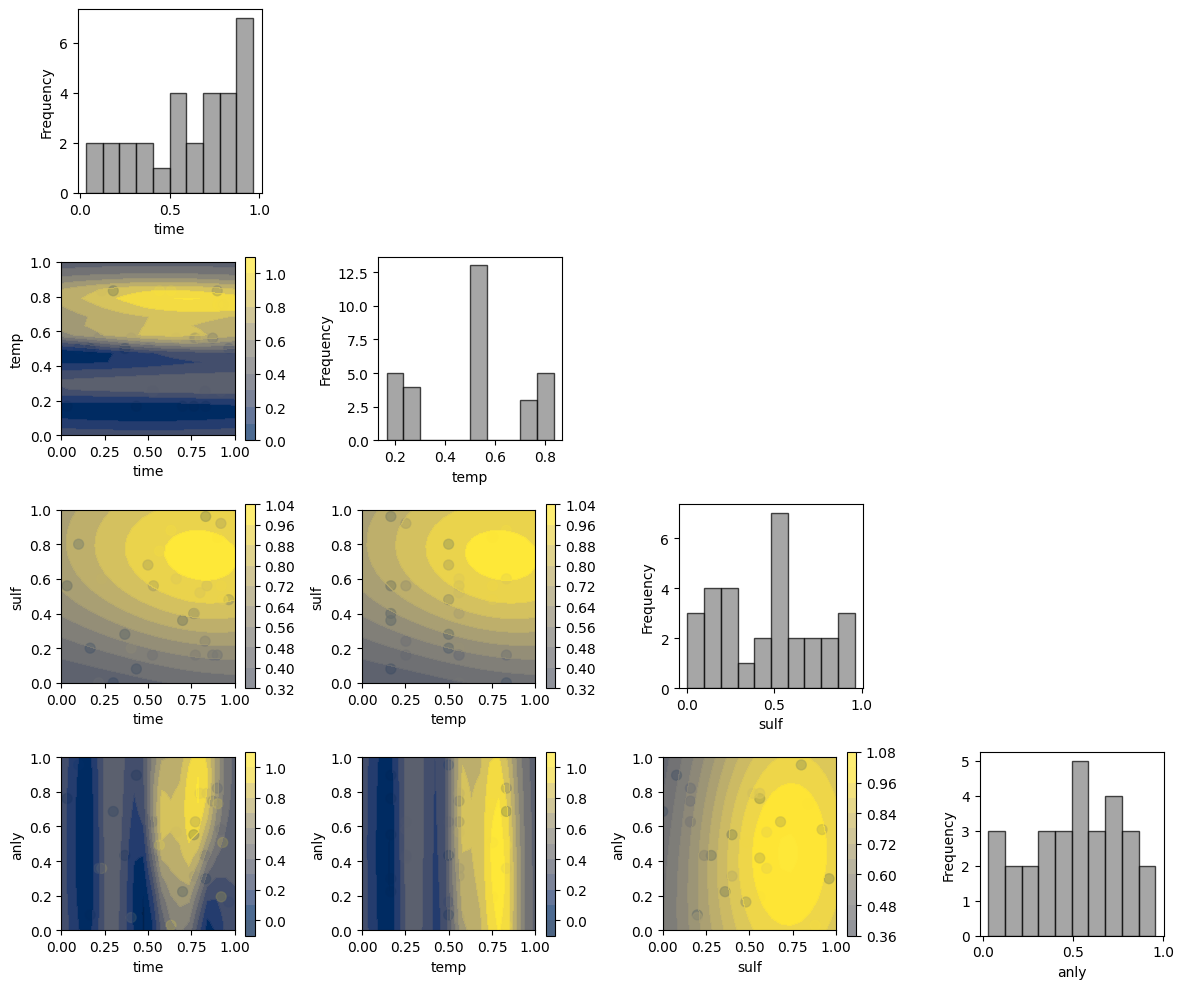

In [5]:
bounds = torch.tensor([[30., 20., 75. , 33.], [600., 170., 100.,100.]], dtype=dtype, device=device) #torch.stack([torch.zeros(4), 100 * torch.ones(4)])

x = torch.tensor([set_dataA['time'],set_dataA['temp'],set_dataA['sulf'],set_dataA['anly']],dtype=torch.float32).T#
norm_x = normalize(x, bounds)
y = torch.tensor(set_dataA['yield product'],dtype=torch.float32).reshape(-1,1)
yvar = torch.tensor(set_dataA['var yield'],dtype=torch.float32).reshape(-1,1)

train_x = torch.tensor(norm_x, dtype=dtype).to(device=device, dtype=dtype)
train_y = torch.tensor(y, dtype=dtype)
train_yvar = torch.tensor(yvar, dtype=dtype)

## Create the surrogate model
gp_model = HeteroskedasticSingleTaskGP(norm_x, train_y, train_yvar, outcome_transform=None, input_transform=None) 
mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
fit_gpytorch_model(mll)

# Visualized the Model
# Generate a grid
num_points = 20  # Points per axis for plotting
a = np.linspace(0, 1, num_points)
b = np.linspace(0, 1, num_points)
c_fixed = 0.75  # Example fixed value for c - three temperatures
d_fixed =  0.75 # Example fixed value for d - three temperatures

# # Create meshgrid for a, b
A, B = np.meshgrid(a, b)

mean_values = []
var_values = []
for combination in variable_combinations:
    input_data = generate_input_data(A, B, c_fixed, d_fixed, combination)
    mean, var =  gp_evaluate(gp_model, input_data)
    mean_values.append(mean)
    var_values.append(var)

staircase_plot_with_histograms('mean', mean_values, var_values, train_x, train_y, train_yvar , input_data, 'cividis', f"Combination: {combination}")


>## Optimization

In [10]:
# Add random seed 
torch.manual_seed(51)

# BO Set up
BO_bounds = torch.tensor([[0., 0., 0. , 0], [1., 1., 1.,1.]], dtype=dtype, device=device)
batch_size = 15 
# For EI aquisition function
best_f = torch.tensor(1.0 ,dtype=dtype) 
# Set up the qEI acquisition function
qEI = qExpectedImprovement(model=gp_model, best_f=best_f)

# Optimize the acquisition function
candidate, _ = optimize_acqf(
    acq_function=qEI ,
    bounds=BO_bounds,
    q=batch_size,
    num_restarts=15,
    raw_samples=100,
    options={"dtype": dtype, "device": device}
)

# Unnormalize the candidate
unnorm_candidate = unnormalize(candidate, bounds)

# Create a dataframe for the candidate
data = {
    'time': unnorm_candidate[:,0]//1,
    'temp': unnorm_candidate[:,1]//1,
    'sulf': unnorm_candidate[:,2]//1,
    'anly': unnorm_candidate[:,3]//1
}
data_df = pd.DataFrame(data)
data_df

,time,temp,sulf,anly
0,255.0,115.0,88.0,71.0
1,332.0,134.0,92.0,67.0
2,319.0,141.0,100.0,67.0
3,329.0,114.0,92.0,93.0
4,310.0,69.0,96.0,43.0
5,511.0,55.0,83.0,34.0
6,399.0,122.0,96.0,63.0
7,269.0,136.0,97.0,43.0
8,359.0,84.0,79.0,71.0
9,506.0,47.0,96.0,67.0


Centroids of Temperature Clusters:
[[ 67. 119. 138.]]


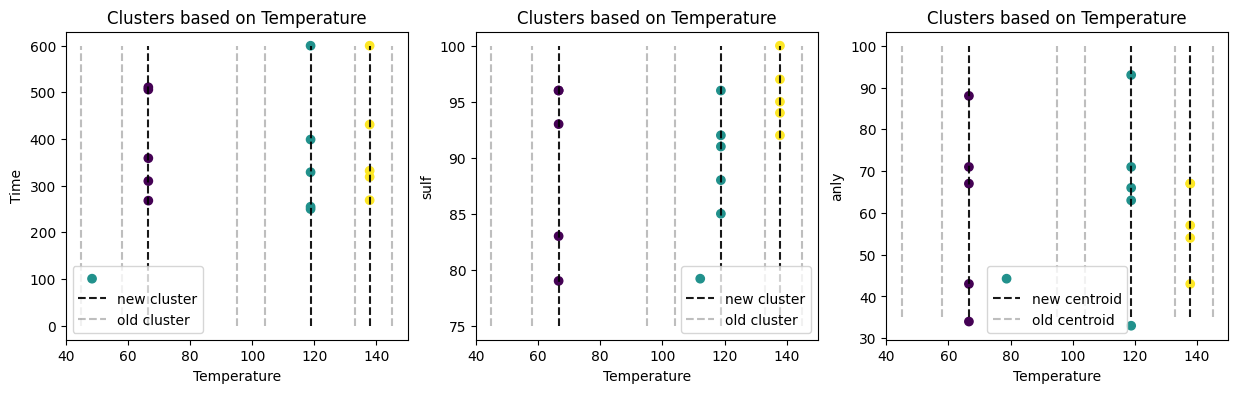

,time,temp,sulf,anly,temp_cluster
0,255.0,119.0,88.0,71.0,1
1,332.0,138.0,92.0,67.0,2
2,319.0,138.0,100.0,67.0,2
3,329.0,119.0,92.0,93.0,1
4,310.0,67.0,96.0,43.0,0
5,511.0,67.0,83.0,34.0,0
6,399.0,119.0,96.0,63.0,1
7,269.0,138.0,97.0,43.0,2
8,359.0,67.0,79.0,71.0,0
9,506.0,67.0,96.0,67.0,0


In [11]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Select the 'temp' column for clustering
temp_data = data_df[['temp']]

# Select the 'temp' column for clustering
temp_data = data_df[['temp']]

# Standardize the data (important for K-Means)
scaler = StandardScaler()
temp_data_scaled = scaler.fit_transform(temp_data)

# Choose the number of clusters
num_clusters = 3

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, n_init=int((20+170)//2), random_state=42)

data_df['temp_cluster'] = kmeans.fit_predict(temp_data_scaled)
kmeans.fit(temp_data)

# Get the centroids
centroids = kmeans.cluster_centers_
centroids.round()

# old centroids
old = [45.,145.,95.,104.,58.,133.]

# Display the centroids
print("Centroids of Temperature Clusters:")
print(centroids.round().T)

# Replace the temperature values in lhs_data with the centroid temperatures for the designated clusters
for cluster in range(num_clusters):
    data_df.loc[data_df['temp_cluster'] == cluster, 'temp'] = centroids[cluster][0]

# Visualize the clusters
fig = plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.scatter(data_df['temp'], data_df['time'], c=data_df['temp_cluster'], cmap='viridis')
plt.vlines(centroids,0,600, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,0,600, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('Time')
plt.title('Clusters based on Temperature')
plt.legend(['','new cluster','old cluster'])

plt.subplot(1,3,2)
plt.scatter(data_df['temp'], data_df['sulf'], c=data_df['temp_cluster'], cmap='viridis')
plt.vlines(centroids,75,100, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,75,100, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('sulf')
plt.title('Clusters based on Temperature')
plt.legend(['','new cluster','old cluster'])


plt.subplot(1,3,3)
plt.scatter(data_df['temp'], data_df['anly'], c=data_df['temp_cluster'], cmap='viridis')
plt.vlines(centroids,35,100, color = 'k',linestyle='dashed',alpha=0.9)
plt.vlines(old,35,100, color = 'tab:grey',linestyle='dashed',alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('anly')
plt.title('Clusters based on Temperature')
plt.legend(['','new centroid','old centroid'])

plt.show()

# Display the updated lhs_data
data_df.round()

>### Send to Data Collection